### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/IntProject')

In [31]:

import sys

del sys.modules['data_func']
import sys

del sys.modules['utils']
del sys.modules['model']


In [32]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [33]:
# pip install tqdm

In [34]:
# pip install torchvision

### Data Preparation & Augmentation

In [35]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [36]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
], )

In [37]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask',
                           './drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=2)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                            './drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/test_mask_lacken', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True, num_workers=2)
    dict_file = './drive/MyDrive/IntProject/train/model_results1.txt'
    model_file = './drive/MyDrive/IntProject/train/model1.pt'
else:
    train_set = ImageDataset('./train/', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val/', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results1.txt'
    model_file = './model1.pt'


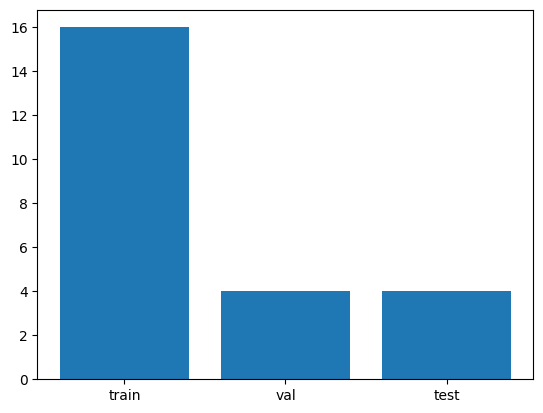

In [38]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

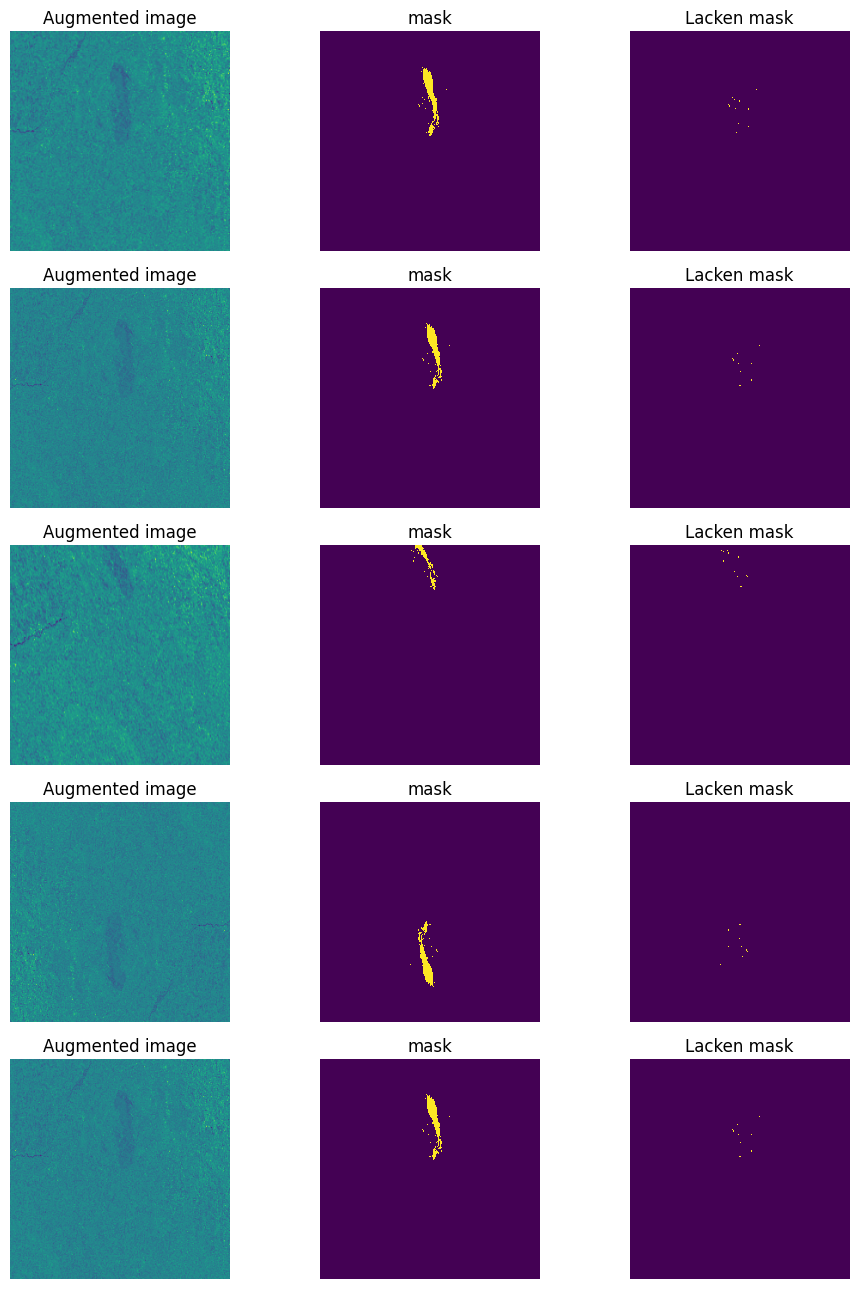

In [39]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [40]:
epochs = 100
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
grad_scaler = torch.cuda.amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
global_step = 0

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_10419/2000960285.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()


In [41]:

train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
               model_file, best_dice=0, patience=10)

  1%|          | 1/100 [00:42<1:10:24, 42.67s/it]

 
 Epoch: 1 
TRAIN FUll: Train Loss: 1.6753 | Train DICE Coeff: 0.0331  | Train IoU Coeff: 0.0119|  | Train Accuracy: 55.38 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0005|  | Train Accuracy: 55.16 
VAL FULL: Val Loss: 1.6808 | Val DICE Coeff: 0.0038 | Val IoU Coeff: 0.0024| Val Accuracy: 38.96| 
VAL LACKENS: Val DICE Coeff: 0.0002 | Val IoU Coeff: 0.0001| Val Accuracy: 39.35| 


  2%|▏         | 2/100 [01:24<1:08:27, 41.91s/it]

 
 Epoch: 2 
TRAIN FUll: Train Loss: 1.4770 | Train DICE Coeff: 0.1179  | Train IoU Coeff: 0.0611|  | Train Accuracy: 95.99 
TRAIN LACKENS: Train DICE Coeff: 0.0030  | Train IoU Coeff: 0.0015|  | Train Accuracy: 96.17 
VAL FULL: Val Loss: 1.7419 | Val DICE Coeff: 0.0152 | Val IoU Coeff: 0.0076| Val Accuracy: 0.77| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001| Val Accuracy: 0.02| 


  3%|▎         | 3/100 [02:09<1:10:01, 43.32s/it]

 
 Epoch: 3 
TRAIN FUll: Train Loss: 1.3950 | Train DICE Coeff: 0.3366  | Train IoU Coeff: 0.2491|  | Train Accuracy: 98.47 
TRAIN LACKENS: Train DICE Coeff: 0.0059  | Train IoU Coeff: 0.0024|  | Train Accuracy: 98.39 
VAL FULL: Val Loss: 1.5498 | Val DICE Coeff: 0.0456 | Val IoU Coeff: 0.0306| Val Accuracy: 93.92| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001| Val Accuracy: 94.37| 


  4%|▍         | 4/100 [02:50<1:08:10, 42.61s/it]

 
 Epoch: 4 
TRAIN FUll: Train Loss: 1.3477 | Train DICE Coeff: 0.2434  | Train IoU Coeff: 0.1930|  | Train Accuracy: 99.39 
TRAIN LACKENS: Train DICE Coeff: 0.0300  | Train IoU Coeff: 0.0037|  | Train Accuracy: 99.75 
VAL FULL: Val Loss: 1.5060 | Val DICE Coeff: 0.0222 | Val IoU Coeff: 0.0117| Val Accuracy: 93.99| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001| Val Accuracy: 94.62| 


  5%|▌         | 5/100 [03:31<1:06:46, 42.18s/it]

 
 Epoch: 5 
TRAIN FUll: Train Loss: 1.3073 | Train DICE Coeff: 0.3953  | Train IoU Coeff: 0.3206|  | Train Accuracy: 99.21 
TRAIN LACKENS: Train DICE Coeff: 0.0140  | Train IoU Coeff: 0.0066|  | Train Accuracy: 99.23 
VAL FULL: Val Loss: 1.1254 | Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0002| Val Accuracy: 97.76| 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0002| Val Accuracy: 98.45| 


  6%|▌         | 6/100 [04:13<1:05:44, 41.96s/it]

 
 Epoch: 6 
TRAIN FUll: Train Loss: 1.2754 | Train DICE Coeff: 0.4331  | Train IoU Coeff: 0.3568|  | Train Accuracy: 99.44 
TRAIN LACKENS: Train DICE Coeff: 0.0438  | Train IoU Coeff: 0.0169|  | Train Accuracy: 99.48 
VAL FULL: Val Loss: 1.2219 | Val DICE Coeff: 0.1463 | Val IoU Coeff: 0.0971| Val Accuracy: 99.16| 
VAL LACKENS: Val DICE Coeff: 0.0608 | Val IoU Coeff: 0.0018| Val Accuracy: 99.78| 


  7%|▋         | 7/100 [04:54<1:04:20, 41.51s/it]

 
 Epoch: 7 
TRAIN FUll: Train Loss: 1.2395 | Train DICE Coeff: 0.5323  | Train IoU Coeff: 0.4176|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0261  | Train IoU Coeff: 0.0086|  | Train Accuracy: 98.91 
VAL FULL: Val Loss: 1.2133 | Val DICE Coeff: 0.0821 | Val IoU Coeff: 0.0615| Val Accuracy: 99.01| 
VAL LACKENS: Val DICE Coeff: 0.0669 | Val IoU Coeff: 0.0013| Val Accuracy: 99.71| 


  8%|▊         | 8/100 [05:35<1:03:30, 41.42s/it]

 
 Epoch: 8 
TRAIN FUll: Train Loss: 1.2192 | Train DICE Coeff: 0.4922  | Train IoU Coeff: 0.4145|  | Train Accuracy: 99.46 
TRAIN LACKENS: Train DICE Coeff: 0.0442  | Train IoU Coeff: 0.0182|  | Train Accuracy: 99.30 
VAL FULL: Val Loss: 1.2551 | Val DICE Coeff: 0.2839 | Val IoU Coeff: 0.0759| Val Accuracy: 93.13| 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0006| Val Accuracy: 92.76| 


  9%|▉         | 9/100 [06:15<1:02:26, 41.17s/it]

 
 Epoch: 9 
TRAIN FUll: Train Loss: 1.1922 | Train DICE Coeff: 0.4719  | Train IoU Coeff: 0.3500|  | Train Accuracy: 99.06 
TRAIN LACKENS: Train DICE Coeff: 0.0136  | Train IoU Coeff: 0.0067|  | Train Accuracy: 98.80 
VAL FULL: Val Loss: 1.1839 | Val DICE Coeff: 0.4547 | Val IoU Coeff: 0.2839| Val Accuracy: 98.86| 
VAL LACKENS: Val DICE Coeff: 0.0178 | Val IoU Coeff: 0.0013| Val Accuracy: 98.83| 


 10%|█         | 10/100 [06:56<1:01:41, 41.13s/it]

 
 Epoch: 10 
TRAIN FUll: Train Loss: 1.1604 | Train DICE Coeff: 0.4782  | Train IoU Coeff: 0.3845|  | Train Accuracy: 99.03 
TRAIN LACKENS: Train DICE Coeff: 0.0343  | Train IoU Coeff: 0.0078|  | Train Accuracy: 98.62 
VAL FULL: Val Loss: 1.1538 | Val DICE Coeff: 0.5112 | Val IoU Coeff: 0.3934| Val Accuracy: 99.27| 
VAL LACKENS: Val DICE Coeff: 0.0204 | Val IoU Coeff: 0.0020| Val Accuracy: 99.04| 


 11%|█         | 11/100 [07:38<1:00:57, 41.10s/it]

 
 Epoch: 11 
TRAIN FUll: Train Loss: 1.1389 | Train DICE Coeff: 0.5311  | Train IoU Coeff: 0.4317|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0182  | Train IoU Coeff: 0.0075|  | Train Accuracy: 98.93 
VAL FULL: Val Loss: 1.0807 | Val DICE Coeff: 0.6065 | Val IoU Coeff: 0.3960| Val Accuracy: 99.07| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0011| Val Accuracy: 98.59| 


 12%|█▏        | 12/100 [08:18<1:00:00, 40.91s/it]

 
 Epoch: 12 
TRAIN FUll: Train Loss: 1.1158 | Train DICE Coeff: 0.5380  | Train IoU Coeff: 0.4072|  | Train Accuracy: 99.12 
TRAIN LACKENS: Train DICE Coeff: 0.0212  | Train IoU Coeff: 0.0089|  | Train Accuracy: 98.71 
VAL FULL: Val Loss: 1.1295 | Val DICE Coeff: 0.4149 | Val IoU Coeff: 0.1656| Val Accuracy: 96.78| 
VAL LACKENS: Val DICE Coeff: 0.0022 | Val IoU Coeff: 0.0011| Val Accuracy: 96.27| 


 13%|█▎        | 13/100 [08:59<59:11, 40.82s/it]  

 
 Epoch: 13 
TRAIN FUll: Train Loss: 1.1065 | Train DICE Coeff: 0.4714  | Train IoU Coeff: 0.3596|  | Train Accuracy: 99.07 
TRAIN LACKENS: Train DICE Coeff: 0.0339  | Train IoU Coeff: 0.0097|  | Train Accuracy: 98.79 
VAL FULL: Val Loss: 1.1129 | Val DICE Coeff: 0.5126 | Val IoU Coeff: 0.3721| Val Accuracy: 99.45| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0009| Val Accuracy: 99.56| 


 14%|█▍        | 14/100 [09:39<58:28, 40.79s/it]

 
 Epoch: 14 
TRAIN FUll: Train Loss: 1.0934 | Train DICE Coeff: 0.4892  | Train IoU Coeff: 0.3662|  | Train Accuracy: 98.70 
TRAIN LACKENS: Train DICE Coeff: 0.0199  | Train IoU Coeff: 0.0062|  | Train Accuracy: 98.39 
VAL FULL: Val Loss: 1.0776 | Val DICE Coeff: 0.4734 | Val IoU Coeff: 0.3882| Val Accuracy: 99.49| 
VAL LACKENS: Val DICE Coeff: 0.0185 | Val IoU Coeff: 0.0009| Val Accuracy: 99.57| 


 15%|█▌        | 15/100 [10:22<58:24, 41.23s/it]

 
 Epoch: 15 
TRAIN FUll: Train Loss: 1.0734 | Train DICE Coeff: 0.5089  | Train IoU Coeff: 0.4017|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0166  | Train IoU Coeff: 0.0045|  | Train Accuracy: 99.13 
VAL FULL: Val Loss: 1.0735 | Val DICE Coeff: 0.3454 | Val IoU Coeff: 0.3168| Val Accuracy: 99.23| 
VAL LACKENS: Val DICE Coeff: 0.0316 | Val IoU Coeff: 0.0021| Val Accuracy: 99.29| 


 16%|█▌        | 16/100 [24:26<6:36:23, 283.14s/it]

 
 Epoch: 16 
TRAIN FUll: Train Loss: 1.0479 | Train DICE Coeff: 0.5259  | Train IoU Coeff: 0.4159|  | Train Accuracy: 99.15 
TRAIN LACKENS: Train DICE Coeff: 0.0371  | Train IoU Coeff: 0.0091|  | Train Accuracy: 98.73 
VAL FULL: Val Loss: 1.0803 | Val DICE Coeff: 0.4555 | Val IoU Coeff: 0.3521| Val Accuracy: 99.03| 
VAL LACKENS: Val DICE Coeff: 0.0169 | Val IoU Coeff: 0.0019| Val Accuracy: 98.77| 


 17%|█▋        | 17/100 [25:13<4:53:05, 211.87s/it]

 
 Epoch: 17 
TRAIN FUll: Train Loss: 1.0379 | Train DICE Coeff: 0.5336  | Train IoU Coeff: 0.4067|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0359  | Train IoU Coeff: 0.0084|  | Train Accuracy: 98.99 
VAL FULL: Val Loss: 1.2729 | Val DICE Coeff: 0.2408 | Val IoU Coeff: 0.0564| Val Accuracy: 90.79| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0005| Val Accuracy: 90.50| 


 18%|█▊        | 18/100 [25:53<3:39:11, 160.38s/it]

 
 Epoch: 18 
TRAIN FUll: Train Loss: 1.0358 | Train DICE Coeff: 0.4153  | Train IoU Coeff: 0.2832|  | Train Accuracy: 98.53 
TRAIN LACKENS: Train DICE Coeff: 0.0431  | Train IoU Coeff: 0.0102|  | Train Accuracy: 98.14 
VAL FULL: Val Loss: 1.0492 | Val DICE Coeff: 0.3661 | Val IoU Coeff: 0.2724| Val Accuracy: 98.38| 
VAL LACKENS: Val DICE Coeff: 0.0254 | Val IoU Coeff: 0.0017| Val Accuracy: 97.94| 


 19%|█▉        | 19/100 [26:34<2:47:53, 124.37s/it]

 
 Epoch: 19 
TRAIN FUll: Train Loss: 1.0246 | Train DICE Coeff: 0.5012  | Train IoU Coeff: 0.3438|  | Train Accuracy: 98.97 
TRAIN LACKENS: Train DICE Coeff: 0.0367  | Train IoU Coeff: 0.0121|  | Train Accuracy: 98.58 
VAL FULL: Val Loss: 1.0154 | Val DICE Coeff: 0.5837 | Val IoU Coeff: 0.4665| Val Accuracy: 99.25| 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0016| Val Accuracy: 98.80| 


 20%|██        | 20/100 [27:14<2:12:07, 99.09s/it] 

 
 Epoch: 20 
TRAIN FUll: Train Loss: 1.0175 | Train DICE Coeff: 0.5414  | Train IoU Coeff: 0.4378|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0407  | Train IoU Coeff: 0.0118|  | Train Accuracy: 99.01 
VAL FULL: Val Loss: 1.0211 | Val DICE Coeff: 0.6011 | Val IoU Coeff: 0.5314| Val Accuracy: 99.52| 
VAL LACKENS: Val DICE Coeff: 0.0075 | Val IoU Coeff: 0.0005| Val Accuracy: 99.19| 


 21%|██        | 21/100 [27:54<1:47:03, 81.32s/it]

 
 Epoch: 21 
TRAIN FUll: Train Loss: 1.0191 | Train DICE Coeff: 0.5446  | Train IoU Coeff: 0.4419|  | Train Accuracy: 99.36 
TRAIN LACKENS: Train DICE Coeff: 0.0349  | Train IoU Coeff: 0.0091|  | Train Accuracy: 99.01 
VAL FULL: Val Loss: 1.0195 | Val DICE Coeff: 0.6119 | Val IoU Coeff: 0.5197| Val Accuracy: 99.49| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0014| Val Accuracy: 99.18| 


 22%|██▏       | 22/100 [28:34<1:29:32, 68.88s/it]

 
 Epoch: 22 
TRAIN FUll: Train Loss: 1.0211 | Train DICE Coeff: 0.5138  | Train IoU Coeff: 0.4037|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0373  | Train IoU Coeff: 0.0100|  | Train Accuracy: 99.01 
VAL FULL: Val Loss: 1.0221 | Val DICE Coeff: 0.6154 | Val IoU Coeff: 0.5132| Val Accuracy: 99.53| 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0005| Val Accuracy: 99.28| 


 23%|██▎       | 23/100 [29:14<1:17:25, 60.33s/it]

 
 Epoch: 23 
TRAIN FUll: Train Loss: 1.0179 | Train DICE Coeff: 0.5262  | Train IoU Coeff: 0.4094|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0241  | Train IoU Coeff: 0.0116|  | Train Accuracy: 98.96 
VAL FULL: Val Loss: 1.0092 | Val DICE Coeff: 0.5873 | Val IoU Coeff: 0.5293| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0124 | Val IoU Coeff: 0.0026| Val Accuracy: 99.13| 


 24%|██▍       | 24/100 [29:54<1:08:49, 54.33s/it]

 
 Epoch: 24 
TRAIN FUll: Train Loss: 1.0082 | Train DICE Coeff: 0.5415  | Train IoU Coeff: 0.4258|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0419  | Train IoU Coeff: 0.0126|  | Train Accuracy: 98.92 
VAL FULL: Val Loss: 0.9999 | Val DICE Coeff: 0.6278 | Val IoU Coeff: 0.5309| Val Accuracy: 99.51| 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0018| Val Accuracy: 99.13| 


 25%|██▌       | 25/100 [30:35<1:02:50, 50.27s/it]

 
 Epoch: 25 
TRAIN FUll: Train Loss: 1.0087 | Train DICE Coeff: 0.5224  | Train IoU Coeff: 0.4152|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0315  | Train IoU Coeff: 0.0108|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9895 | Val DICE Coeff: 0.6051 | Val IoU Coeff: 0.5311| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0064 | Val IoU Coeff: 0.0004| Val Accuracy: 99.06| 


 26%|██▌       | 26/100 [31:16<58:26, 47.39s/it]  

 
 Epoch: 26 
TRAIN FUll: Train Loss: 1.0010 | Train DICE Coeff: 0.5467  | Train IoU Coeff: 0.4250|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0344  | Train IoU Coeff: 0.0105|  | Train Accuracy: 98.90 
VAL FULL: Val Loss: 0.9956 | Val DICE Coeff: 0.6296 | Val IoU Coeff: 0.4850| Val Accuracy: 99.45| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0010| Val Accuracy: 99.20| 


 27%|██▋       | 27/100 [31:56<55:11, 45.36s/it]

 
 Epoch: 27 
TRAIN FUll: Train Loss: 1.0072 | Train DICE Coeff: 0.5270  | Train IoU Coeff: 0.4134|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0384  | Train IoU Coeff: 0.0136|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 1.0023 | Val DICE Coeff: 0.5919 | Val IoU Coeff: 0.4519| Val Accuracy: 99.40| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0005| Val Accuracy: 99.17| 


 28%|██▊       | 28/100 [32:37<52:43, 43.94s/it]

 
 Epoch: 28 
TRAIN FUll: Train Loss: 0.9936 | Train DICE Coeff: 0.5498  | Train IoU Coeff: 0.4312|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0295  | Train IoU Coeff: 0.0123|  | Train Accuracy: 98.72 
VAL FULL: Val Loss: 0.9994 | Val DICE Coeff: 0.5454 | Val IoU Coeff: 0.4051| Val Accuracy: 99.22| 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0024| Val Accuracy: 98.90| 


 29%|██▉       | 29/100 [33:18<51:04, 43.16s/it]

 
 Epoch: 29 
TRAIN FUll: Train Loss: 0.9987 | Train DICE Coeff: 0.5375  | Train IoU Coeff: 0.4218|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0288  | Train IoU Coeff: 0.0113|  | Train Accuracy: 98.83 
VAL FULL: Val Loss: 1.0022 | Val DICE Coeff: 0.5791 | Val IoU Coeff: 0.4621| Val Accuracy: 99.47| 
VAL LACKENS: Val DICE Coeff: 0.0095 | Val IoU Coeff: 0.0043| Val Accuracy: 99.21| 


 30%|███       | 30/100 [34:00<49:57, 42.82s/it]

 
 Epoch: 30 
TRAIN FUll: Train Loss: 0.9974 | Train DICE Coeff: 0.5383  | Train IoU Coeff: 0.4094|  | Train Accuracy: 99.16 
TRAIN LACKENS: Train DICE Coeff: 0.0213  | Train IoU Coeff: 0.0118|  | Train Accuracy: 98.76 
VAL FULL: Val Loss: 0.9907 | Val DICE Coeff: 0.6366 | Val IoU Coeff: 0.5155| Val Accuracy: 99.52| 
VAL LACKENS: Val DICE Coeff: 0.0056 | Val IoU Coeff: 0.0019| Val Accuracy: 99.21| 


 31%|███       | 31/100 [34:42<48:50, 42.47s/it]

 
 Epoch: 31 
TRAIN FUll: Train Loss: 0.9964 | Train DICE Coeff: 0.5414  | Train IoU Coeff: 0.4255|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0341  | Train IoU Coeff: 0.0133|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9794 | Val DICE Coeff: 0.6478 | Val IoU Coeff: 0.5099| Val Accuracy: 99.42| 
VAL LACKENS: Val DICE Coeff: 0.0034 | Val IoU Coeff: 0.0012| Val Accuracy: 99.05| 


 32%|███▏      | 32/100 [35:28<49:11, 43.41s/it]

 
 Epoch: 32 
TRAIN FUll: Train Loss: 0.9937 | Train DICE Coeff: 0.5359  | Train IoU Coeff: 0.4235|  | Train Accuracy: 99.25 
TRAIN LACKENS: Train DICE Coeff: 0.0393  | Train IoU Coeff: 0.0140|  | Train Accuracy: 98.86 
VAL FULL: Val Loss: 0.9783 | Val DICE Coeff: 0.6351 | Val IoU Coeff: 0.5274| Val Accuracy: 99.45| 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0012| Val Accuracy: 99.06| 


 33%|███▎      | 33/100 [39:46<2:00:28, 107.89s/it]

 
 Epoch: 33 
TRAIN FUll: Train Loss: 0.9933 | Train DICE Coeff: 0.5584  | Train IoU Coeff: 0.4498|  | Train Accuracy: 99.36 
TRAIN LACKENS: Train DICE Coeff: 0.0317  | Train IoU Coeff: 0.0106|  | Train Accuracy: 98.96 
VAL FULL: Val Loss: 0.9907 | Val DICE Coeff: 0.5893 | Val IoU Coeff: 0.4876| Val Accuracy: 99.43| 
VAL LACKENS: Val DICE Coeff: 0.0053 | Val IoU Coeff: 0.0009| Val Accuracy: 99.16| 


 34%|███▍      | 34/100 [40:27<1:36:31, 87.75s/it] 

 
 Epoch: 34 
TRAIN FUll: Train Loss: 0.9977 | Train DICE Coeff: 0.5404  | Train IoU Coeff: 0.4176|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0278  | Train IoU Coeff: 0.0109|  | Train Accuracy: 98.94 
VAL FULL: Val Loss: 0.9764 | Val DICE Coeff: 0.6596 | Val IoU Coeff: 0.5285| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0024 | Val IoU Coeff: 0.0004| Val Accuracy: 99.07| 


 35%|███▌      | 35/100 [41:07<1:19:30, 73.40s/it]

 
 Epoch: 35 
TRAIN FUll: Train Loss: 0.9865 | Train DICE Coeff: 0.5552  | Train IoU Coeff: 0.4525|  | Train Accuracy: 99.35 
TRAIN LACKENS: Train DICE Coeff: 0.0423  | Train IoU Coeff: 0.0125|  | Train Accuracy: 98.95 
VAL FULL: Val Loss: 0.9784 | Val DICE Coeff: 0.6161 | Val IoU Coeff: 0.4991| Val Accuracy: 99.39| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0004| Val Accuracy: 99.06| 


 36%|███▌      | 36/100 [41:47<1:07:46, 63.54s/it]

 
 Epoch: 36 
TRAIN FUll: Train Loss: 0.9872 | Train DICE Coeff: 0.5579  | Train IoU Coeff: 0.4510|  | Train Accuracy: 99.34 
TRAIN LACKENS: Train DICE Coeff: 0.0357  | Train IoU Coeff: 0.0144|  | Train Accuracy: 98.94 
VAL FULL: Val Loss: 0.9798 | Val DICE Coeff: 0.6382 | Val IoU Coeff: 0.5423| Val Accuracy: 99.53| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0014| Val Accuracy: 99.17| 


 37%|███▋      | 37/100 [42:28<59:26, 56.61s/it]  

 
 Epoch: 37 
TRAIN FUll: Train Loss: 0.9895 | Train DICE Coeff: 0.5563  | Train IoU Coeff: 0.4363|  | Train Accuracy: 99.34 
TRAIN LACKENS: Train DICE Coeff: 0.0370  | Train IoU Coeff: 0.0111|  | Train Accuracy: 98.97 
VAL FULL: Val Loss: 0.9750 | Val DICE Coeff: 0.6399 | Val IoU Coeff: 0.5396| Val Accuracy: 99.53| 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0019| Val Accuracy: 99.19| 


 38%|███▊      | 38/100 [43:08<53:34, 51.85s/it]

 
 Epoch: 38 
TRAIN FUll: Train Loss: 0.9823 | Train DICE Coeff: 0.5509  | Train IoU Coeff: 0.4298|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0377  | Train IoU Coeff: 0.0177|  | Train Accuracy: 98.88 
VAL FULL: Val Loss: 0.9653 | Val DICE Coeff: 0.6820 | Val IoU Coeff: 0.5558| Val Accuracy: 99.54| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0023| Val Accuracy: 99.19| 


 39%|███▉      | 39/100 [43:49<49:13, 48.43s/it]

 
 Epoch: 39 
TRAIN FUll: Train Loss: 0.9855 | Train DICE Coeff: 0.5423  | Train IoU Coeff: 0.4149|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0404  | Train IoU Coeff: 0.0113|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9567 | Val DICE Coeff: 0.6539 | Val IoU Coeff: 0.5286| Val Accuracy: 99.41| 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0019| Val Accuracy: 98.98| 


 40%|████      | 40/100 [44:29<46:03, 46.06s/it]

 
 Epoch: 40 
TRAIN FUll: Train Loss: 0.9796 | Train DICE Coeff: 0.5462  | Train IoU Coeff: 0.4206|  | Train Accuracy: 99.22 
TRAIN LACKENS: Train DICE Coeff: 0.0415  | Train IoU Coeff: 0.0117|  | Train Accuracy: 98.79 
VAL FULL: Val Loss: 0.9644 | Val DICE Coeff: 0.6162 | Val IoU Coeff: 0.5286| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0004| Val Accuracy: 99.07| 


 41%|████      | 41/100 [45:10<43:47, 44.54s/it]

 
 Epoch: 41 
TRAIN FUll: Train Loss: 0.9730 | Train DICE Coeff: 0.5583  | Train IoU Coeff: 0.4389|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0341  | Train IoU Coeff: 0.0117|  | Train Accuracy: 98.83 
VAL FULL: Val Loss: 0.9751 | Val DICE Coeff: 0.6565 | Val IoU Coeff: 0.5333| Val Accuracy: 99.52| 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0031| Val Accuracy: 99.15| 


 42%|████▏     | 42/100 [45:51<41:52, 43.31s/it]

 
 Epoch: 42 
TRAIN FUll: Train Loss: 0.9829 | Train DICE Coeff: 0.5534  | Train IoU Coeff: 0.4208|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0345  | Train IoU Coeff: 0.0144|  | Train Accuracy: 98.92 
VAL FULL: Val Loss: 0.9608 | Val DICE Coeff: 0.6596 | Val IoU Coeff: 0.5333| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0009| Val Accuracy: 99.16| 


 43%|████▎     | 43/100 [46:31<40:20, 42.47s/it]

 
 Epoch: 43 
TRAIN FUll: Train Loss: 0.9720 | Train DICE Coeff: 0.5583  | Train IoU Coeff: 0.4321|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0334  | Train IoU Coeff: 0.0140|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9773 | Val DICE Coeff: 0.6281 | Val IoU Coeff: 0.4864| Val Accuracy: 99.48| 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0029| Val Accuracy: 99.22| 


 44%|████▍     | 44/100 [47:12<39:17, 42.10s/it]

 
 Epoch: 44 
TRAIN FUll: Train Loss: 0.9685 | Train DICE Coeff: 0.5689  | Train IoU Coeff: 0.4347|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0276  | Train IoU Coeff: 0.0134|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 0.9572 | Val DICE Coeff: 0.6219 | Val IoU Coeff: 0.5214| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0008| Val Accuracy: 99.05| 


 45%|████▌     | 45/100 [47:53<38:16, 41.75s/it]

 
 Epoch: 45 
TRAIN FUll: Train Loss: 0.9815 | Train DICE Coeff: 0.5371  | Train IoU Coeff: 0.3987|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0310  | Train IoU Coeff: 0.0140|  | Train Accuracy: 98.82 
VAL FULL: Val Loss: 0.9579 | Val DICE Coeff: 0.6099 | Val IoU Coeff: 0.5241| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0065 | Val IoU Coeff: 0.0016| Val Accuracy: 99.03| 


 46%|████▌     | 46/100 [48:34<37:23, 41.55s/it]

 
 Epoch: 46 
TRAIN FUll: Train Loss: 0.9714 | Train DICE Coeff: 0.5253  | Train IoU Coeff: 0.3998|  | Train Accuracy: 99.10 
TRAIN LACKENS: Train DICE Coeff: 0.0332  | Train IoU Coeff: 0.0112|  | Train Accuracy: 98.64 
VAL FULL: Val Loss: 0.9656 | Val DICE Coeff: 0.5775 | Val IoU Coeff: 0.4635| Val Accuracy: 99.33| 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0018| Val Accuracy: 98.94| 


 47%|████▋     | 47/100 [49:17<36:51, 41.73s/it]

 
 Epoch: 47 
TRAIN FUll: Train Loss: 0.9712 | Train DICE Coeff: 0.5465  | Train IoU Coeff: 0.4450|  | Train Accuracy: 99.32 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0157|  | Train Accuracy: 98.89 
VAL FULL: Val Loss: 0.9493 | Val DICE Coeff: 0.6475 | Val IoU Coeff: 0.5272| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0011| Val Accuracy: 98.99| 


 48%|████▊     | 48/100 [49:58<36:11, 41.76s/it]

 
 Epoch: 48 
TRAIN FUll: Train Loss: 0.9676 | Train DICE Coeff: 0.5539  | Train IoU Coeff: 0.4585|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0352  | Train IoU Coeff: 0.0204|  | Train Accuracy: 98.93 
VAL FULL: Val Loss: 0.9695 | Val DICE Coeff: 0.5776 | Val IoU Coeff: 0.5065| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0190 | Val IoU Coeff: 0.0014| Val Accuracy: 99.21| 


 49%|████▉     | 49/100 [50:39<35:10, 41.38s/it]

 
 Epoch: 49 
TRAIN FUll: Train Loss: 0.9649 | Train DICE Coeff: 0.5524  | Train IoU Coeff: 0.4491|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0334  | Train IoU Coeff: 0.0137|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9494 | Val DICE Coeff: 0.6758 | Val IoU Coeff: 0.5455| Val Accuracy: 99.48| 
VAL LACKENS: Val DICE Coeff: 0.0038 | Val IoU Coeff: 0.0016| Val Accuracy: 99.04| 


 50%|█████     | 50/100 [51:20<34:24, 41.29s/it]

 
 Epoch: 50 
TRAIN FUll: Train Loss: 0.9626 | Train DICE Coeff: 0.5803  | Train IoU Coeff: 0.4653|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0312  | Train IoU Coeff: 0.0119|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9523 | Val DICE Coeff: 0.6240 | Val IoU Coeff: 0.4927| Val Accuracy: 99.32| 
VAL LACKENS: Val DICE Coeff: 0.0033 | Val IoU Coeff: 0.0010| Val Accuracy: 98.81| 


 51%|█████     | 51/100 [52:01<33:38, 41.20s/it]

 
 Epoch: 51 
TRAIN FUll: Train Loss: 0.9625 | Train DICE Coeff: 0.5850  | Train IoU Coeff: 0.4376|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0269  | Train IoU Coeff: 0.0143|  | Train Accuracy: 98.67 
VAL FULL: Val Loss: 0.9607 | Val DICE Coeff: 0.6103 | Val IoU Coeff: 0.5300| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0069 | Val IoU Coeff: 0.0013| Val Accuracy: 99.13| 


 52%|█████▏    | 52/100 [52:42<32:54, 41.14s/it]

 
 Epoch: 52 
TRAIN FUll: Train Loss: 0.9628 | Train DICE Coeff: 0.5732  | Train IoU Coeff: 0.4370|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0304  | Train IoU Coeff: 0.0119|  | Train Accuracy: 98.78 
VAL FULL: Val Loss: 0.9418 | Val DICE Coeff: 0.6760 | Val IoU Coeff: 0.5279| Val Accuracy: 99.39| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0017| Val Accuracy: 98.85| 


 53%|█████▎    | 53/100 [53:22<32:01, 40.87s/it]

 
 Epoch: 53 
TRAIN FUll: Train Loss: 0.9724 | Train DICE Coeff: 0.5643  | Train IoU Coeff: 0.4292|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0372  | Train IoU Coeff: 0.0174|  | Train Accuracy: 98.99 
VAL FULL: Val Loss: 0.9576 | Val DICE Coeff: 0.6702 | Val IoU Coeff: 0.5309| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0027 | Val IoU Coeff: 0.0009| Val Accuracy: 99.12| 


 54%|█████▍    | 54/100 [54:03<31:20, 40.87s/it]

 
 Epoch: 54 
TRAIN FUll: Train Loss: 0.9687 | Train DICE Coeff: 0.5469  | Train IoU Coeff: 0.4415|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0468  | Train IoU Coeff: 0.0150|  | Train Accuracy: 98.91 
VAL FULL: Val Loss: 0.9405 | Val DICE Coeff: 0.6751 | Val IoU Coeff: 0.5404| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0025| Val Accuracy: 98.95| 


 55%|█████▌    | 55/100 [54:44<30:37, 40.83s/it]

 
 Epoch: 55 
TRAIN FUll: Train Loss: 0.9682 | Train DICE Coeff: 0.5671  | Train IoU Coeff: 0.4233|  | Train Accuracy: 99.22 
TRAIN LACKENS: Train DICE Coeff: 0.0352  | Train IoU Coeff: 0.0157|  | Train Accuracy: 98.80 
VAL FULL: Val Loss: 0.9504 | Val DICE Coeff: 0.6401 | Val IoU Coeff: 0.4947| Val Accuracy: 99.36| 
VAL LACKENS: Val DICE Coeff: 0.0037 | Val IoU Coeff: 0.0018| Val Accuracy: 98.93| 


 56%|█████▌    | 56/100 [55:25<29:56, 40.84s/it]

 
 Epoch: 56 
TRAIN FUll: Train Loss: 0.9638 | Train DICE Coeff: 0.5673  | Train IoU Coeff: 0.4329|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0364  | Train IoU Coeff: 0.0174|  | Train Accuracy: 98.82 
VAL FULL: Val Loss: 0.9605 | Val DICE Coeff: 0.6476 | Val IoU Coeff: 0.5322| Val Accuracy: 99.52| 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0013| Val Accuracy: 99.13| 


 57%|█████▋    | 57/100 [56:06<29:26, 41.07s/it]

 
 Epoch: 57 
TRAIN FUll: Train Loss: 0.9767 | Train DICE Coeff: 0.5595  | Train IoU Coeff: 0.4358|  | Train Accuracy: 99.34 
TRAIN LACKENS: Train DICE Coeff: 0.0389  | Train IoU Coeff: 0.0190|  | Train Accuracy: 98.97 
VAL FULL: Val Loss: 0.9565 | Val DICE Coeff: 0.6858 | Val IoU Coeff: 0.5371| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0017| Val Accuracy: 99.08| 


 58%|█████▊    | 58/100 [56:47<28:44, 41.06s/it]

 
 Epoch: 58 
TRAIN FUll: Train Loss: 0.9739 | Train DICE Coeff: 0.5432  | Train IoU Coeff: 0.4121|  | Train Accuracy: 99.22 
TRAIN LACKENS: Train DICE Coeff: 0.0331  | Train IoU Coeff: 0.0144|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9493 | Val DICE Coeff: 0.6830 | Val IoU Coeff: 0.5347| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0023| Val Accuracy: 99.00| 


 59%|█████▉    | 59/100 [57:28<27:57, 40.92s/it]

 
 Epoch: 59 
TRAIN FUll: Train Loss: 0.9692 | Train DICE Coeff: 0.5455  | Train IoU Coeff: 0.4310|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0325  | Train IoU Coeff: 0.0117|  | Train Accuracy: 98.80 
VAL FULL: Val Loss: 0.9718 | Val DICE Coeff: 0.5605 | Val IoU Coeff: 0.4734| Val Accuracy: 99.42| 
VAL LACKENS: Val DICE Coeff: 0.0096 | Val IoU Coeff: 0.0032| Val Accuracy: 99.06| 


 60%|██████    | 60/100 [58:09<27:16, 40.92s/it]

 
 Epoch: 60 
TRAIN FUll: Train Loss: 0.9751 | Train DICE Coeff: 0.5341  | Train IoU Coeff: 0.4128|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0438  | Train IoU Coeff: 0.0142|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 0.9717 | Val DICE Coeff: 0.5604 | Val IoU Coeff: 0.4430| Val Accuracy: 99.34| 
VAL LACKENS: Val DICE Coeff: 0.0093 | Val IoU Coeff: 0.0042| Val Accuracy: 99.02| 


 61%|██████    | 61/100 [58:50<26:38, 41.00s/it]

 
 Epoch: 61 
TRAIN FUll: Train Loss: 0.9745 | Train DICE Coeff: 0.5375  | Train IoU Coeff: 0.3957|  | Train Accuracy: 99.22 
TRAIN LACKENS: Train DICE Coeff: 0.0314  | Train IoU Coeff: 0.0120|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9566 | Val DICE Coeff: 0.6633 | Val IoU Coeff: 0.5205| Val Accuracy: 99.48| 
VAL LACKENS: Val DICE Coeff: 0.0033 | Val IoU Coeff: 0.0013| Val Accuracy: 99.09| 


 62%|██████▏   | 62/100 [59:32<26:04, 41.18s/it]

 
 Epoch: 62 
TRAIN FUll: Train Loss: 0.9736 | Train DICE Coeff: 0.5479  | Train IoU Coeff: 0.4326|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0365  | Train IoU Coeff: 0.0150|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9488 | Val DICE Coeff: 0.6044 | Val IoU Coeff: 0.4684| Val Accuracy: 99.22| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0012| Val Accuracy: 98.68| 


 63%|██████▎   | 63/100 [1:00:13<25:21, 41.12s/it]

 
 Epoch: 63 
TRAIN FUll: Train Loss: 0.9660 | Train DICE Coeff: 0.5484  | Train IoU Coeff: 0.4406|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0477  | Train IoU Coeff: 0.0162|  | Train Accuracy: 98.79 
VAL FULL: Val Loss: 0.9459 | Val DICE Coeff: 0.6605 | Val IoU Coeff: 0.5132| Val Accuracy: 99.39| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0010| Val Accuracy: 98.89| 


 64%|██████▍   | 64/100 [1:00:53<24:36, 41.00s/it]

 
 Epoch: 64 
TRAIN FUll: Train Loss: 0.9662 | Train DICE Coeff: 0.5560  | Train IoU Coeff: 0.4131|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0332  | Train IoU Coeff: 0.0168|  | Train Accuracy: 98.74 
VAL FULL: Val Loss: 0.9504 | Val DICE Coeff: 0.6622 | Val IoU Coeff: 0.4893| Val Accuracy: 99.32| 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0029| Val Accuracy: 98.83| 


 65%|██████▌   | 65/100 [1:01:34<23:52, 40.92s/it]

 
 Epoch: 65 
TRAIN FUll: Train Loss: 0.9785 | Train DICE Coeff: 0.5187  | Train IoU Coeff: 0.4040|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0168|  | Train Accuracy: 98.88 
VAL FULL: Val Loss: 0.9536 | Val DICE Coeff: 0.6385 | Val IoU Coeff: 0.5223| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0019| Val Accuracy: 98.98| 


 66%|██████▌   | 66/100 [1:02:15<23:06, 40.78s/it]

 
 Epoch: 66 
TRAIN FUll: Train Loss: 0.9660 | Train DICE Coeff: 0.5632  | Train IoU Coeff: 0.4433|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0392  | Train IoU Coeff: 0.0158|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 0.9429 | Val DICE Coeff: 0.6364 | Val IoU Coeff: 0.4940| Val Accuracy: 99.29| 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0003| Val Accuracy: 98.79| 


 67%|██████▋   | 67/100 [1:02:56<22:28, 40.85s/it]

 
 Epoch: 67 
TRAIN FUll: Train Loss: 0.9723 | Train DICE Coeff: 0.5546  | Train IoU Coeff: 0.4226|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0285  | Train IoU Coeff: 0.0148|  | Train Accuracy: 98.83 
VAL FULL: Val Loss: 0.9569 | Val DICE Coeff: 0.6446 | Val IoU Coeff: 0.5286| Val Accuracy: 99.49| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0013| Val Accuracy: 99.09| 


 68%|██████▊   | 68/100 [1:03:37<21:56, 41.13s/it]

 
 Epoch: 68 
TRAIN FUll: Train Loss: 0.9695 | Train DICE Coeff: 0.5617  | Train IoU Coeff: 0.4348|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0403  | Train IoU Coeff: 0.0149|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9403 | Val DICE Coeff: 0.6761 | Val IoU Coeff: 0.5232| Val Accuracy: 99.39| 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023| Val Accuracy: 98.87| 


 69%|██████▉   | 69/100 [1:04:18<21:14, 41.11s/it]

 
 Epoch: 69 
TRAIN FUll: Train Loss: 0.9655 | Train DICE Coeff: 0.5598  | Train IoU Coeff: 0.4470|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0434  | Train IoU Coeff: 0.0130|  | Train Accuracy: 98.88 
VAL FULL: Val Loss: 0.9482 | Val DICE Coeff: 0.6788 | Val IoU Coeff: 0.5346| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0004| Val Accuracy: 99.01| 


 70%|███████   | 70/100 [1:05:00<20:35, 41.18s/it]

 
 Epoch: 70 
TRAIN FUll: Train Loss: 0.9636 | Train DICE Coeff: 0.5678  | Train IoU Coeff: 0.4609|  | Train Accuracy: 99.32 
TRAIN LACKENS: Train DICE Coeff: 0.0430  | Train IoU Coeff: 0.0137|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9489 | Val DICE Coeff: 0.6447 | Val IoU Coeff: 0.5047| Val Accuracy: 99.34| 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0026| Val Accuracy: 98.81| 


 71%|███████   | 71/100 [1:05:41<19:55, 41.21s/it]

 
 Epoch: 71 
TRAIN FUll: Train Loss: 0.9709 | Train DICE Coeff: 0.5349  | Train IoU Coeff: 0.4174|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0436  | Train IoU Coeff: 0.0094|  | Train Accuracy: 98.78 
VAL FULL: Val Loss: 0.9612 | Val DICE Coeff: 0.6572 | Val IoU Coeff: 0.5170| Val Accuracy: 99.47| 
VAL LACKENS: Val DICE Coeff: 0.0039 | Val IoU Coeff: 0.0016| Val Accuracy: 99.06| 


 72%|███████▏  | 72/100 [1:06:23<19:23, 41.57s/it]

 
 Epoch: 72 
TRAIN FUll: Train Loss: 0.9673 | Train DICE Coeff: 0.5529  | Train IoU Coeff: 0.4366|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0336  | Train IoU Coeff: 0.0133|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9508 | Val DICE Coeff: 0.6047 | Val IoU Coeff: 0.4891| Val Accuracy: 99.33| 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0013| Val Accuracy: 98.86| 


 73%|███████▎  | 73/100 [1:07:06<18:52, 41.96s/it]

 
 Epoch: 73 
TRAIN FUll: Train Loss: 0.9757 | Train DICE Coeff: 0.5430  | Train IoU Coeff: 0.4196|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0419  | Train IoU Coeff: 0.0109|  | Train Accuracy: 98.91 
VAL FULL: Val Loss: 0.9592 | Val DICE Coeff: 0.6311 | Val IoU Coeff: 0.5183| Val Accuracy: 99.47| 
VAL LACKENS: Val DICE Coeff: 0.0039 | Val IoU Coeff: 0.0008| Val Accuracy: 99.09| 


 74%|███████▍  | 74/100 [1:07:48<18:10, 41.93s/it]

 
 Epoch: 74 
TRAIN FUll: Train Loss: 0.9620 | Train DICE Coeff: 0.5726  | Train IoU Coeff: 0.4593|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0347  | Train IoU Coeff: 0.0140|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9784 | Val DICE Coeff: 0.5462 | Val IoU Coeff: 0.4386| Val Accuracy: 99.41| 
VAL LACKENS: Val DICE Coeff: 0.0096 | Val IoU Coeff: 0.0028| Val Accuracy: 99.18| 


 75%|███████▌  | 75/100 [1:08:30<17:29, 41.98s/it]

 
 Epoch: 75 
TRAIN FUll: Train Loss: 0.9640 | Train DICE Coeff: 0.5688  | Train IoU Coeff: 0.4484|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0295  | Train IoU Coeff: 0.0144|  | Train Accuracy: 98.82 
VAL FULL: Val Loss: 0.9333 | Val DICE Coeff: 0.6895 | Val IoU Coeff: 0.5324| Val Accuracy: 99.35| 
VAL LACKENS: Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0018| Val Accuracy: 98.76| 


 76%|███████▌  | 76/100 [1:09:11<16:41, 41.73s/it]

 
 Epoch: 76 
TRAIN FUll: Train Loss: 0.9643 | Train DICE Coeff: 0.5702  | Train IoU Coeff: 0.4651|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0102|  | Train Accuracy: 98.88 
VAL FULL: Val Loss: 0.9436 | Val DICE Coeff: 0.6893 | Val IoU Coeff: 0.5409| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0029 | Val IoU Coeff: 0.0011| Val Accuracy: 98.97| 


 77%|███████▋  | 77/100 [1:09:53<15:55, 41.56s/it]

 
 Epoch: 77 
TRAIN FUll: Train Loss: 0.9566 | Train DICE Coeff: 0.5814  | Train IoU Coeff: 0.4706|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0315  | Train IoU Coeff: 0.0176|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9601 | Val DICE Coeff: 0.5986 | Val IoU Coeff: 0.4745| Val Accuracy: 99.34| 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0025| Val Accuracy: 98.92| 


 78%|███████▊  | 78/100 [1:10:35<15:19, 41.81s/it]

 
 Epoch: 78 
TRAIN FUll: Train Loss: 0.9782 | Train DICE Coeff: 0.5254  | Train IoU Coeff: 0.4172|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0458  | Train IoU Coeff: 0.0093|  | Train Accuracy: 98.91 
VAL FULL: Val Loss: 0.9534 | Val DICE Coeff: 0.5962 | Val IoU Coeff: 0.5113| Val Accuracy: 99.43| 
VAL LACKENS: Val DICE Coeff: 0.0069 | Val IoU Coeff: 0.0012| Val Accuracy: 99.06| 


 79%|███████▉  | 79/100 [1:11:17<14:37, 41.79s/it]

 
 Epoch: 79 
TRAIN FUll: Train Loss: 0.9646 | Train DICE Coeff: 0.5749  | Train IoU Coeff: 0.4477|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0327  | Train IoU Coeff: 0.0150|  | Train Accuracy: 98.83 
VAL FULL: Val Loss: 0.9419 | Val DICE Coeff: 0.7132 | Val IoU Coeff: 0.5734| Val Accuracy: 99.51| 
VAL LACKENS: Val DICE Coeff: 0.0018 | Val IoU Coeff: 0.0004| Val Accuracy: 98.97| 


 80%|████████  | 80/100 [1:11:58<13:54, 41.73s/it]

 
 Epoch: 80 
TRAIN FUll: Train Loss: 0.9744 | Train DICE Coeff: 0.5317  | Train IoU Coeff: 0.4368|  | Train Accuracy: 99.32 
TRAIN LACKENS: Train DICE Coeff: 0.0455  | Train IoU Coeff: 0.0142|  | Train Accuracy: 98.93 
VAL FULL: Val Loss: 0.9444 | Val DICE Coeff: 0.6692 | Val IoU Coeff: 0.5093| Val Accuracy: 99.37| 
VAL LACKENS: Val DICE Coeff: 0.0016 | Val IoU Coeff: 0.0004| Val Accuracy: 98.96| 


 81%|████████  | 81/100 [1:12:40<13:11, 41.68s/it]

 
 Epoch: 81 
TRAIN FUll: Train Loss: 0.9654 | Train DICE Coeff: 0.5895  | Train IoU Coeff: 0.4420|  | Train Accuracy: 99.21 
TRAIN LACKENS: Train DICE Coeff: 0.0248  | Train IoU Coeff: 0.0114|  | Train Accuracy: 98.72 
VAL FULL: Val Loss: 0.9505 | Val DICE Coeff: 0.6128 | Val IoU Coeff: 0.4908| Val Accuracy: 99.33| 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0020| Val Accuracy: 98.83| 


 82%|████████▏ | 82/100 [1:13:21<12:28, 41.57s/it]

 
 Epoch: 82 
TRAIN FUll: Train Loss: 0.9709 | Train DICE Coeff: 0.5481  | Train IoU Coeff: 0.4234|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0119|  | Train Accuracy: 98.88 
VAL FULL: Val Loss: 0.9413 | Val DICE Coeff: 0.6708 | Val IoU Coeff: 0.5190| Val Accuracy: 99.36| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0013| Val Accuracy: 98.80| 


 83%|████████▎ | 83/100 [1:14:04<11:51, 41.86s/it]

 
 Epoch: 83 
TRAIN FUll: Train Loss: 0.9649 | Train DICE Coeff: 0.5512  | Train IoU Coeff: 0.4374|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0383  | Train IoU Coeff: 0.0112|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9604 | Val DICE Coeff: 0.6423 | Val IoU Coeff: 0.5290| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0026| Val Accuracy: 99.12| 


 84%|████████▍ | 84/100 [1:14:46<11:09, 41.85s/it]

 
 Epoch: 84 
TRAIN FUll: Train Loss: 0.9712 | Train DICE Coeff: 0.5587  | Train IoU Coeff: 0.4373|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0375  | Train IoU Coeff: 0.0189|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9416 | Val DICE Coeff: 0.6966 | Val IoU Coeff: 0.5761| Val Accuracy: 99.52| 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0016| Val Accuracy: 99.03| 


 85%|████████▌ | 85/100 [1:15:27<10:26, 41.75s/it]

 
 Epoch: 85 
TRAIN FUll: Train Loss: 0.9725 | Train DICE Coeff: 0.5368  | Train IoU Coeff: 0.4093|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0363  | Train IoU Coeff: 0.0148|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9510 | Val DICE Coeff: 0.6508 | Val IoU Coeff: 0.5144| Val Accuracy: 99.42| 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0023| Val Accuracy: 99.00| 


 86%|████████▌ | 86/100 [1:16:08<09:40, 41.48s/it]

 
 Epoch: 86 
TRAIN FUll: Train Loss: 0.9716 | Train DICE Coeff: 0.5434  | Train IoU Coeff: 0.4204|  | Train Accuracy: 99.21 
TRAIN LACKENS: Train DICE Coeff: 0.0326  | Train IoU Coeff: 0.0108|  | Train Accuracy: 98.80 
VAL FULL: Val Loss: 0.9419 | Val DICE Coeff: 0.6618 | Val IoU Coeff: 0.5329| Val Accuracy: 99.42| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0018| Val Accuracy: 98.94| 


 87%|████████▋ | 87/100 [1:16:49<08:57, 41.33s/it]

 
 Epoch: 87 
TRAIN FUll: Train Loss: 0.9604 | Train DICE Coeff: 0.5904  | Train IoU Coeff: 0.4602|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0322  | Train IoU Coeff: 0.0129|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9589 | Val DICE Coeff: 0.6478 | Val IoU Coeff: 0.5230| Val Accuracy: 99.49| 
VAL LACKENS: Val DICE Coeff: 0.0032 | Val IoU Coeff: 0.0008| Val Accuracy: 99.08| 


 88%|████████▊ | 88/100 [1:17:30<08:13, 41.14s/it]

 
 Epoch: 88 
TRAIN FUll: Train Loss: 0.9608 | Train DICE Coeff: 0.5730  | Train IoU Coeff: 0.4458|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0320  | Train IoU Coeff: 0.0129|  | Train Accuracy: 98.81 
VAL FULL: Val Loss: 0.9649 | Val DICE Coeff: 0.6310 | Val IoU Coeff: 0.5188| Val Accuracy: 99.51| 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0014| Val Accuracy: 99.17| 


 89%|████████▉ | 89/100 [1:18:11<07:32, 41.10s/it]

 
 Epoch: 89 
TRAIN FUll: Train Loss: 0.9655 | Train DICE Coeff: 0.5619  | Train IoU Coeff: 0.4361|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0307  | Train IoU Coeff: 0.0124|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 0.9640 | Val DICE Coeff: 0.6466 | Val IoU Coeff: 0.5295| Val Accuracy: 99.54| 
VAL LACKENS: Val DICE Coeff: 0.0033 | Val IoU Coeff: 0.0005| Val Accuracy: 99.21| 


 90%|█████████ | 90/100 [1:18:52<06:52, 41.24s/it]

 
 Epoch: 90 
TRAIN FUll: Train Loss: 0.9646 | Train DICE Coeff: 0.5478  | Train IoU Coeff: 0.4369|  | Train Accuracy: 99.21 
TRAIN LACKENS: Train DICE Coeff: 0.0265  | Train IoU Coeff: 0.0152|  | Train Accuracy: 98.73 
VAL FULL: Val Loss: 0.9579 | Val DICE Coeff: 0.6444 | Val IoU Coeff: 0.5288| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0009| Val Accuracy: 99.10| 


 91%|█████████ | 91/100 [1:19:33<06:09, 41.11s/it]

 
 Epoch: 91 
TRAIN FUll: Train Loss: 0.9674 | Train DICE Coeff: 0.5585  | Train IoU Coeff: 0.4395|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0411  | Train IoU Coeff: 0.0159|  | Train Accuracy: 98.86 
VAL FULL: Val Loss: 0.9573 | Val DICE Coeff: 0.6191 | Val IoU Coeff: 0.5060| Val Accuracy: 99.43| 
VAL LACKENS: Val DICE Coeff: 0.0038 | Val IoU Coeff: 0.0008| Val Accuracy: 99.02| 


 92%|█████████▏| 92/100 [1:20:15<05:30, 41.32s/it]

 
 Epoch: 92 
TRAIN FUll: Train Loss: 0.9654 | Train DICE Coeff: 0.5624  | Train IoU Coeff: 0.4320|  | Train Accuracy: 99.25 
TRAIN LACKENS: Train DICE Coeff: 0.0308  | Train IoU Coeff: 0.0107|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9478 | Val DICE Coeff: 0.6335 | Val IoU Coeff: 0.5314| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0015| Val Accuracy: 98.97| 


 93%|█████████▎| 93/100 [1:20:56<04:48, 41.18s/it]

 
 Epoch: 93 
TRAIN FUll: Train Loss: 0.9671 | Train DICE Coeff: 0.5669  | Train IoU Coeff: 0.4510|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0409  | Train IoU Coeff: 0.0120|  | Train Accuracy: 98.86 
VAL FULL: Val Loss: 0.9560 | Val DICE Coeff: 0.6256 | Val IoU Coeff: 0.5081| Val Accuracy: 99.44| 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0012| Val Accuracy: 99.02| 


 94%|█████████▍| 94/100 [1:21:37<04:07, 41.18s/it]

 
 Epoch: 94 
TRAIN FUll: Train Loss: 0.9676 | Train DICE Coeff: 0.5778  | Train IoU Coeff: 0.4679|  | Train Accuracy: 99.37 
TRAIN LACKENS: Train DICE Coeff: 0.0291  | Train IoU Coeff: 0.0115|  | Train Accuracy: 98.95 
VAL FULL: Val Loss: 0.9462 | Val DICE Coeff: 0.6655 | Val IoU Coeff: 0.5234| Val Accuracy: 99.41| 
VAL LACKENS: Val DICE Coeff: 0.0039 | Val IoU Coeff: 0.0018| Val Accuracy: 98.95| 


 95%|█████████▌| 95/100 [1:22:20<03:28, 41.66s/it]

 
 Epoch: 95 
TRAIN FUll: Train Loss: 0.9664 | Train DICE Coeff: 0.5736  | Train IoU Coeff: 0.4486|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0292  | Train IoU Coeff: 0.0153|  | Train Accuracy: 98.85 
VAL FULL: Val Loss: 0.9447 | Val DICE Coeff: 0.6617 | Val IoU Coeff: 0.5178| Val Accuracy: 99.39| 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0003| Val Accuracy: 98.90| 


 96%|█████████▌| 96/100 [1:23:00<02:44, 41.20s/it]

 
 Epoch: 96 
TRAIN FUll: Train Loss: 0.9692 | Train DICE Coeff: 0.5548  | Train IoU Coeff: 0.4411|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0361  | Train IoU Coeff: 0.0161|  | Train Accuracy: 98.87 
VAL FULL: Val Loss: 0.9546 | Val DICE Coeff: 0.6445 | Val IoU Coeff: 0.5098| Val Accuracy: 99.42| 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0022| Val Accuracy: 98.94| 


 97%|█████████▋| 97/100 [1:23:41<02:03, 41.11s/it]

 
 Epoch: 97 
TRAIN FUll: Train Loss: 0.9706 | Train DICE Coeff: 0.5381  | Train IoU Coeff: 0.4396|  | Train Accuracy: 99.27 
TRAIN LACKENS: Train DICE Coeff: 0.0351  | Train IoU Coeff: 0.0119|  | Train Accuracy: 98.84 
VAL FULL: Val Loss: 0.9350 | Val DICE Coeff: 0.7041 | Val IoU Coeff: 0.5440| Val Accuracy: 99.40| 
VAL LACKENS: Val DICE Coeff: 0.0028 | Val IoU Coeff: 0.0013| Val Accuracy: 98.83| 


 98%|█████████▊| 98/100 [1:24:22<01:22, 41.05s/it]

 
 Epoch: 98 
TRAIN FUll: Train Loss: 0.9688 | Train DICE Coeff: 0.5530  | Train IoU Coeff: 0.4366|  | Train Accuracy: 99.29 
TRAIN LACKENS: Train DICE Coeff: 0.0363  | Train IoU Coeff: 0.0136|  | Train Accuracy: 98.86 
VAL FULL: Val Loss: 0.9569 | Val DICE Coeff: 0.6301 | Val IoU Coeff: 0.5069| Val Accuracy: 99.43| 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0019| Val Accuracy: 99.00| 


 99%|█████████▉| 99/100 [1:25:03<00:41, 41.15s/it]

 
 Epoch: 99 
TRAIN FUll: Train Loss: 0.9655 | Train DICE Coeff: 0.5696  | Train IoU Coeff: 0.4534|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0347  | Train IoU Coeff: 0.0099|  | Train Accuracy: 98.89 
VAL FULL: Val Loss: 0.9450 | Val DICE Coeff: 0.6632 | Val IoU Coeff: 0.5592| Val Accuracy: 99.49| 
VAL LACKENS: Val DICE Coeff: 0.0038 | Val IoU Coeff: 0.0012| Val Accuracy: 99.01| 


100%|██████████| 100/100 [1:25:47<00:00, 51.47s/it]

 
 Epoch: 100 
TRAIN FUll: Train Loss: 0.9674 | Train DICE Coeff: 0.5163  | Train IoU Coeff: 0.4136|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0307  | Train IoU Coeff: 0.0137|  | Train Accuracy: 98.75 
VAL FULL: Val Loss: 0.9626 | Val DICE Coeff: 0.6393 | Val IoU Coeff: 0.5252| Val Accuracy: 99.50| 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0018| Val Accuracy: 99.15| 


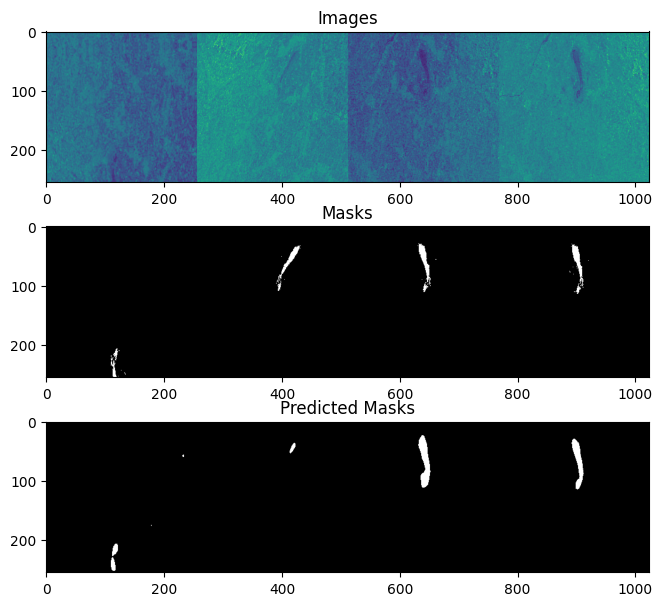

In [42]:
images, masks, lacken_masks = next(iter(testloader))
with torch.no_grad():
    pred = model(images.to(device)).cpu().detach()
    pred = pred > 0.5


def display_batch(images, masks, pred):
    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.numpy()
    masks = masks.numpy()
    pred = pred.numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predicted Masks')


display_batch(images, masks, pred)